In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
train_method = 'valid'

In [14]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
from functools import reduce
import scipy.stats

In [15]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
SAVE_FIGS = True

In [16]:
from cdcp.visualization.colors import colors as cdcp_colors

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [19]:
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [20]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [21]:
identifiers = ['spike_count', 'unit_location', 'time_of_day']

In [22]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)

unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:  10%|█         | 1/10 [00:01<00:10,  1.17s/it]

B1597 nrows per [6750, 8711, 6750]


birds:  20%|██        | 2/10 [00:01<00:04,  1.66it/s]

B1188 nrows per [510, 821, 510]
B1595 nrows per [242, 325, 242]


birds:  50%|█████     | 5/10 [00:01<00:01,  4.05it/s]

B1276 nrows per [46, 57, 46]
B1426 nrows per [93, 180, 93]


birds:  60%|██████    | 6/10 [00:02<00:01,  3.73it/s]

B1432 nrows per [2157, 2364, 2157]


birds:  70%|███████   | 7/10 [00:02<00:00,  3.78it/s]

B1170 nrows per [1281, 1693, 1281]
B1244 nrows per [141, 150, 141]


birds:  90%|█████████ | 9/10 [00:04<00:00,  1.51it/s]

B1593 nrows per [7714, 13260, 7714]


birds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

B1248 nrows per [8698, 13184, 8698]


In [23]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


In [24]:
unit_statistics_df = unit_statistics_df.sort_values(by=['n_active_trials'], ascending=False)

In [25]:
unit_statistics_df[:2]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,AE_unique_hours,AE_hourly_acc,AF_unique_hours,AF_hourly_acc,BF_unique_hours,BF_hourly_acc,BE_unique_hours,BE_hourly_acc,CF_unique_hours,CF_hourly_acc,AG_unique_hours,AG_hourly_acc,BH_unique_hours,BH_hourly_acc,BG_unique_hours,BG_hourly_acc,DF_unique_hours,DF_hourly_acc,DH_unique_hours,DH_hourly_acc,AH_unique_hours,AH_hourly_acc,CE_unique_hours,CE_hourly_acc,CG_unique_hours,CG_hourly_acc,DE_unique_hours,DE_hourly_acc,bird,DG_unique_hours,DG_hourly_acc,CH_unique_hours,CH_hourly_acc,categorical_unit,categoricality,fw,sr,unit_type,best_chan_templates,best_chan_templates_norm,amplitude
1185,135308,22462,2952,21969,7852,108288,27020,3782468,3428,NaN,NaN,NCL,494.54,2731.25,2420.0,-802.499502,"[21, 19, 17, 20, 18]","[0.3393483709273183, 0.35449957947855343, 0.35...","[17, 18, 21, 19, 20]","[0.3161856963613551, 0.3252858958068615, 0.296...","[17, 18, 21, 19, 20]","[0.3307155322862129, 0.32721338229294167, 0.31...","[17, 21, 19, 20, 18]","[0.18192488262910797, 0.1882716049382716, 0.18...","[21, 17, 18, 20, 19]","[0.38225806451612904, 0.36752136752136755, 0.3...","[21, 20, 17, 18, 19]","[0.2605421686746988, 0.23803680981595093, 0.24...","[17, 19, 21, 20, 18]","[0.2185792349726776, 0.23036649214659685, 0.14...","[20, 19, 17, 18, 21]","[0.1763157894736842, 0.18963337547408343, 0.17...","[19, 17, 20, 18, 21]","[0.20418848167539266, 0.16666666666666666, 0.2...","[18, 17, 20, 19, 21]","[0.16842105263157894, 0.21428571428571427, 0.1...","[20, 19, 17, 21, 18]","[0.14594594594594595, 0.2, 0.1956521739130435,...","[18, 17, 21, 19, 20]","[0.23421052631578948, 0.21345407503234154, 0.2...","[19, 21, 18, 17, 20]","[0.26059850374064836, 0.28213166144200624, 0.2...","[18, 20, 17, 21, 19]","[0.14035087719298245, 0.20105820105820105, 0.2...",B1597,NaN,NaN,NaN,NaN,True,0.499018,43.0,25.960996,1,"[14.0, 13.911411411411411, 13.822822822822824,...","[0.01709673880257429, 0.0169885548054323, 0.01...",-560.25
188,62396,16809,1337,17917,5211,42386,20010,1519167,11670,NaN,NaN,Field_L,558.515,2317.25,2420.0,-722.499502,"[21, 17, 19, 20, 18]","[0.21014492753623187, 0.20838471023427868, 0.2...","[20, 19, 17, 18, 21]","[0.23684210526315788, 0.23024054982817868, 0.1...","[20, 17, 19, 18, 21]","[0.2601010101010101, 0.205761316872428, 0.2573...","[19, 20, 18, 17, 21]","[0.13636363636363635, 0.1553784860557769, 0.15...","[20, 19, 21, 17, 18]","[0.22310756972111553, 0.24302788844621515, 0.2...","[20, 17, 21, 19, 18]","[0.1776061776061776, 0.17509727626459143, 0.16...","[17, 21, 19, 20, 18]","[0.1867704280155642, 0.2116788321167883, 0.270...","[20, 18, 21, 17, 19]","[0.11610486891385768, 0.1422924901185771, 0.2,...","[20, 21, 19, 18, 17]","[0.14772727272727273, 0.2702702702702703, 0.19...","[19, 20, 17, 18, 21]","[0.1601423487544484, 0.22692307692307692, 0.13...","[18, 21, 19, 20, 17]","[0.19924812030075187, 0.1554054054054054, 0.16...","[20, 19, 21, 17, 18]","[0.14336917562724014, 0.15546218487394958, 0.1...","[17, 18, 21, 20, 19]","[0.15748031496062992, 0.1893939393939394, 0.17...","[18, 17, 21, 20, 19]","[0.21311475409836064, 0.1532567049808429, 0.25...",B1597,NaN,NaN,NaN,NaN,True,0.433930,85.0,15.855983,0,"[46.5, 46.588588588588586, 46.67717717717718, ...","[0.08471652194211443, 0.08487791800897435, 0.0...",-447.00


In [26]:
unit_statistics_df["bird_unit"] = ["_".join([row.bird, row.unit]) for idx, row in unit_statistics_df.iterrows()]

### Set rows to stims

In [33]:
interps = ['AE', 'AF', 'AG', 'BE', 'BF', 'BG',  'CE', 'CF', 'CG'] #['AE', 'AF', 'BE', 'BF']

In [63]:
acc_df_interp = pd.DataFrame(
    #index = np.arange(len(unit_statistics_df)*len(interps)),
    columns = ['interp', 'unit', 'bird', 'hourly_acc', 'unique_hours'] 
)
i = 0
n_skip = 0
for axi, (idx, row) in tqdm(enumerate(unit_statistics_df.iterrows()), total = len(unit_statistics_df)):
    for interp in interps:    
        
        if type(row[f'{interp}_hourly_acc']) != list:
            continue
        
        if np.mean(row[f'{interp}_hourly_acc']) < 1/16:
            continue
            
        #acc_df_interp.loc[i] = (
        acc_df_interp.loc[len(acc_df_interp)] = (
            [
                interp,
                row.bird_unit,
                row.bird,
                row[f'{interp}_hourly_acc'],
                row[f'{interp}_unique_hours']
                   ]
                
        )
        i+=1

100%|██████████| 6754/6754 [02:53<00:00, 39.01it/s] 


In [64]:
# only include interpolations where there are at least 1 sample for each cue / interp point
prop_units = len(np.unique(acc_df_interp.unit)) / len(unit_statistics_df)
print(f"prop units where sufficient data is available {prop_units}")

prop units where sufficient data is available 0.9157536274800119


In [65]:
acc_df_interp[:3]

,interp,unit,bird,hourly_acc,unique_hours
0,AE,B1597_3428,B1597,"[0.3393483709273183, 0.35449957947855343, 0.35...","[21, 19, 17, 20, 18]"
1,AF,B1597_3428,B1597,"[0.3161856963613551, 0.3252858958068615, 0.296...","[17, 18, 21, 19, 20]"
2,AG,B1597_3428,B1597,"[0.2605421686746988, 0.23803680981595093, 0.24...","[21, 20, 17, 18, 19]"


In [66]:
acc_df_interp['mean_acc'] = [np.mean(i) for i in acc_df_interp.hourly_acc]

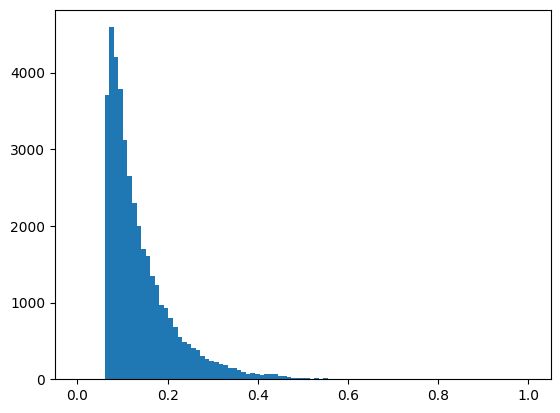

In [67]:
plt.hist(acc_df_interp['mean_acc'], bins = np.linspace(0,1, 100));

In [68]:
acc_df_interp['hourly_acc_rel'] = [i - np.mean(i) for i in acc_df_interp.hourly_acc]

In [69]:
len(np.unique(acc_df_interp.unit))

6185

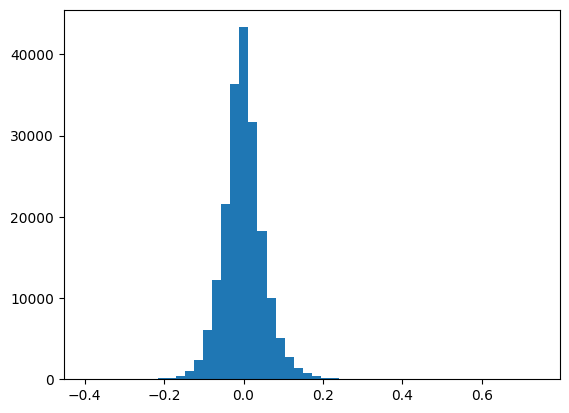

In [79]:
plt.hist(acc, bins=50);

In [125]:
acc = np.concatenate(acc_df_interp['hourly_acc_rel']) * 100
hour = np.concatenate(acc_df_interp['unique_hours'])
hour = np.concatenate(acc_df_interp['unique_hours'])
m = hour<22
hour = hour[m]# disclude the few recordings past 9
acc = acc[m]

In [126]:
import scipy.stats

In [127]:
scipy.stats.pearsonr(hour, acc)

PearsonRResult(statistic=-0.028640961945906, pvalue=1.4328550374974762e-36)

In [116]:
def get_95_ci(x, y, n_resamples = 500, n_x_samples = 100, bounds = 95, x_range = None):
    if x_range is None:
        xmin = np.min(x)
        xmax = np.max(x)
    model_x = np.linspace(xmin, xmax, n_x_samples)
    sample_matrix = np.zeros((n_resamples, n_x_samples))
    for i in tqdm(range(n_resamples), leave=False):
        sample_index = np.random.choice(range(0, len(y)), len(y))
        X_samples = x[sample_index]
        y_samples = y[sample_index] 
        m, b = np.polyfit(X_samples, y_samples, 1)
        sample_matrix[i] = m * model_x + b
    lower_, upper_ = np.percentile(sample_matrix, ((100-bounds)/2, (100-((100-bounds)/2))), axis=0)
    return (lower_, upper_), model_x

In [117]:
(acc_lower, acc_upper), fit_x = get_95_ci(hour, acc)

(-1.0, 1.0)

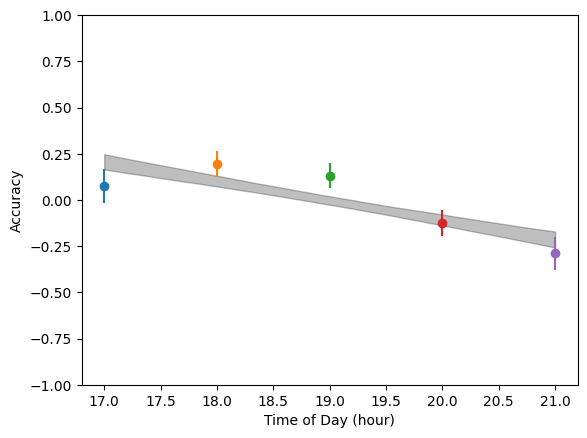

In [121]:
fig, ax = plt.subplots()
ax.fill_between(
        fit_x,
        acc_lower,
        acc_upper,
        color='k',
        alpha=0.25,
    )

for h in np.unique(hour):
    mean_h = np.mean(acc[hour==h])
    std_h = np.std(acc[hour==h])
    sem_h = std_h/np.sqrt(sum(hour==h))
    ax.scatter([h], [mean_h])
    ax.errorbar([h], [mean_h], yerr=3*sem_h)
#ax.axhline(0, color = 'k', ls='dashed')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Time of Day (hour)')
ax.set_ylim([-1,1])
ax.axhline(0, color = 'k', ls='dashed')

In [129]:
acc = np.concatenate(acc_df_interp['hourly_acc']) * 100
hour = np.concatenate(acc_df_interp['unique_hours'])
m = hour<22
hour = hour[m]# disclude the few recordings past 9
acc = acc[m]

In [130]:
(acc_lower, acc_upper), fit_x = get_95_ci(hour, acc)

(13.0, 15.0)

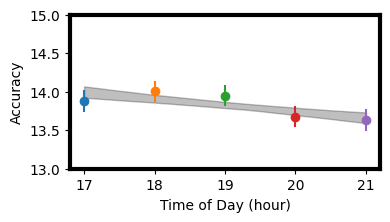

In [131]:
fig, ax = plt.subplots(figsize=(4,2))
ax.fill_between(
        fit_x,
        acc_lower,
        acc_upper,
        color='k',
        alpha=0.25,
    )

for h in np.unique(hour):
    mean_h = np.mean(acc[hour==h])
    std_h = np.std(acc[hour==h])
    sem_h = std_h/np.sqrt(sum(hour==h))
    ax.scatter([h], [mean_h])
    ax.errorbar([h], [mean_h], yerr=3*sem_h)
#ax.axhline(0, color = 'k', ls='dashed')
[i.set_linewidth(3) for i in ax.spines.values()]

ax.set_ylabel('Accuracy')
ax.set_xlabel('Time of Day (hour)')
ax.set_ylim([13,15])